# Paper Analysis

This notebook generates the graphs contained within the paper. It should all just run 🤞

(Make sure you've filled out the config file and unzipped the results if you decide to run it.)

## Loading in the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
from datetime import datetime
import numpy as np
import json

from matplotlib.lines import Line2D
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from mp_sampling import get_ce_mean_and_std, plot_group_similarity_across_runs_simple, plot_group_similarity_across_runs_stepped, get_CE_means_fixed_windows
from analysis_functions import highlight_significant_windows, highlight_significant_changes, get_significant_windows, plot_hlines
from helper_functions import plot_timeline

with open("../project-config.json") as config_file:
    project_config = json.load(config_file)
    
results_fp = project_config["CHUNK_POS_RESULTS_DIR_ALL"]
results_fp_eu = project_config["CHUNK_POS_RESULTS_DIR_EU"]
out_fp = project_config["GRAPHS_DIR"]

kw_dir = project_config["KW_DIR"]

In [2]:
dates_fp = project_config["DATES_FP"]

key_dates = pd.read_csv(dates_fp, delimiter="\t")

convert_to_date = lambda x: datetime.strptime(x, "%d-%m-%Y")
key_dates["date"] = key_dates["date"].apply(convert_to_date)
key_dates.set_index("date", inplace=True)
key_dates = key_dates.sort_index(ascending=True)

In [3]:
def get_CE_comparisons(fp):
    with open(fp) as results_file:
        results = json.load(results_file)

    comparisons = [{gsnap: {gtest: {datetime.strptime(w, "%Y-%m-%d"): pd.Series(run[gsnap][gtest][w]) for w in run[gsnap][gtest]} for gtest in run[gsnap]} for gsnap in run} for run in results["comparisons"]]
    return comparisons

def get_ends_of_windows(fp):
    with open(fp) as results_file:
        results = json.load(results_file)
            
    return [datetime.strptime(w, "%Y-%m-%d") for w in results["end_of_windows"]] 

def plot_significant_changes(curr_runs, curr_end_dates, ax, colour):
    curr_2nd = curr_runs.iloc[1:]
    curr_1st = curr_runs.iloc[:-1].set_index(curr_2nd.index)
    significant_changes = get_significant_windows(curr_2nd, curr_1st, curr_end_dates[1:])
    plot_hlines(significant_changes, ax, colour)

## Do Remainer MPs from Leave Constituencies become more similar to Leavers after the Referendum?

In [4]:
comparisons = get_CE_comparisons(os.path.join(results_fp, "remain_constituency.json"))
end_dates = get_ends_of_windows(os.path.join(results_fp, "remain_constituency.json"))

leaver_r_con_runs = get_CE_means_fixed_windows(comparisons, "Leavers", "Remain_Constituency_Remainers")
leaver_l_con_runs = get_CE_means_fixed_windows(comparisons, "Leavers", "Leave_Constituency_Remainers")

leaver_leaver_runs = get_CE_means_fixed_windows(comparisons, "Leavers", "Leavers")

leaver_r_con_means, leaver_r_con_stds = get_ce_mean_and_std(comparisons, "Leavers", "Remain_Constituency_Remainers")
leaver_l_con_means, leaver_l_con_stds = get_ce_mean_and_std(comparisons, "Leavers", "Leave_Constituency_Remainers")

leaver_leaver_means, leaver_leaver_stds = get_ce_mean_and_std(comparisons, "Leavers", "Leavers")

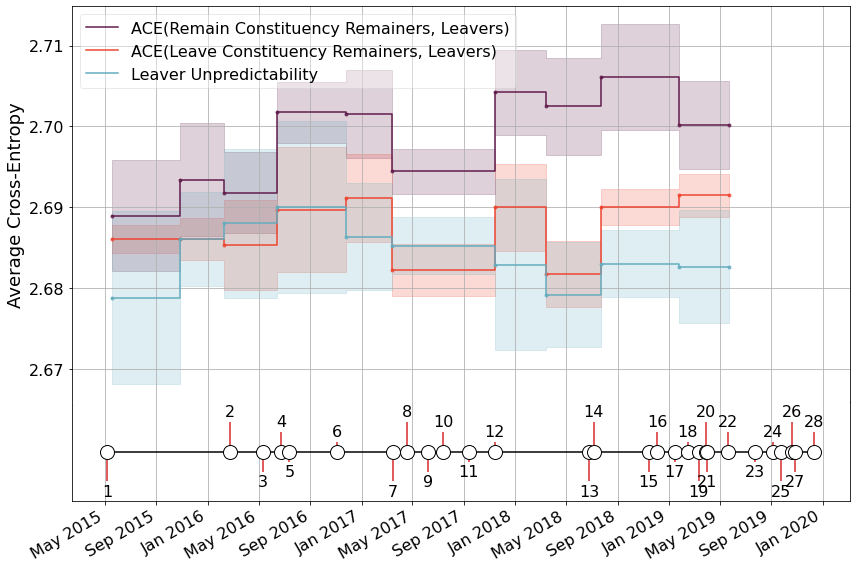

In [17]:
# Comment this back and remove the below chunk if you don't want the timeline
# fig, ax = plt.subplots(figsize=(12, 8))

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0)
ax = plt.subplot(gs[0])
ax_time = plt.subplot(gs[1], sharex=ax)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#601A4A", "#EE442F", "#63ACBE"]

plot_group_similarity_across_runs_stepped(leaver_r_con_means, leaver_r_con_stds, ax, colour=colour_list[0], label='ACE(Remain Constituency Remainers, Leavers)', fill_alpha=0.2, end_dates=end_dates)

plot_group_similarity_across_runs_stepped(leaver_l_con_means, leaver_l_con_stds, ax, colour=colour_list[1], label='ACE(Leave Constituency Remainers, Leavers)', fill_alpha=0.2, end_dates=end_dates)

plot_group_similarity_across_runs_stepped(leaver_leaver_means, leaver_leaver_stds, ax, colour=colour_list[2], label='Leaver Unpredictability', fill_alpha=0.2, end_dates=end_dates)

ax.set_ylabel("Average Cross-Entropy", fontsize=18)

ax.grid()
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, framealpha=0.4)

# Comment this chunk out if you don't want the timeline
names = np.arange(key_dates.shape[0]) + 1
dates = key_dates.index
plot_timeline(ax_time, dates, names, fontsize=16)
plt.setp(ax.get_xticklabels(), visible=False)
ax_time.spines['left'].set_visible(True)
ax_time.spines['right'].set_visible(True)

plt.tight_layout()

# fig.savefig(os.path.join(out_fp, "remainer_constituency_ce.pdf"))

plt.show()

The above graph suggests that for the most part there isn't much of an increase in divergence from either group.
We can get a slightly better impression if we plot the difference between remainer CE and leaver unpredictability.
Here we are treating the leaver unpredictability as a baseline.

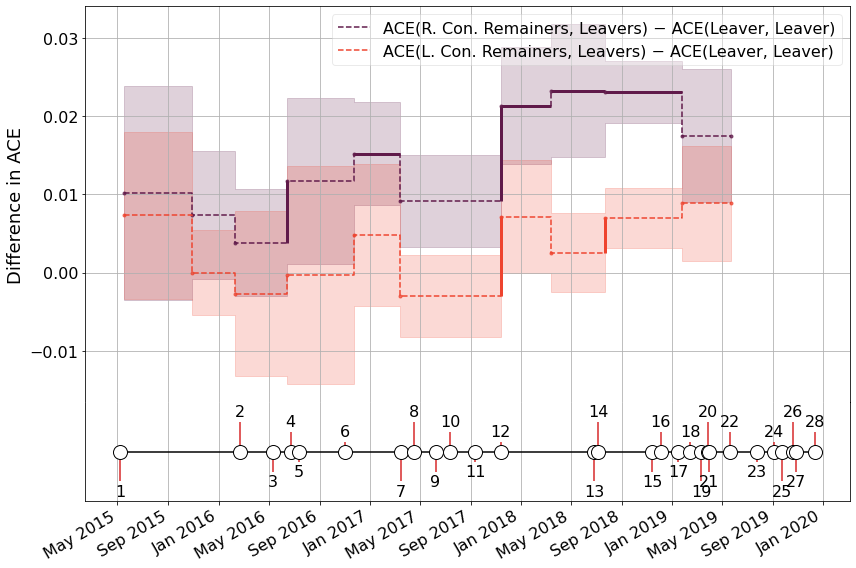

In [20]:
leaver_r_con_diff = leaver_r_con_runs - leaver_leaver_runs
leaver_l_con_diff = leaver_l_con_runs - leaver_leaver_runs

# Comment this back and remove the below chunk if you don't want the timeline
# fig, ax = plt.subplots(figsize=(12, 8))

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0)
ax = plt.subplot(gs[0])
ax_time = plt.subplot(gs[1], sharex=ax)

fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#601A4A", "#EE442F", "#63ACBE"]

means = leaver_r_con_diff.mean(axis=1)
stds = leaver_r_con_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax, colour=colour_list[0], label="ACE(R. Con. Remainers, Leavers) − ACE(Leaver, Leaver)", line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=end_dates)
highlight_significant_changes(leaver_r_con_diff, end_dates, ax, colour_list[0], line_alpha=0)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(leaver_r_con_runs, leaver_leaver_runs, end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax, colour_list[0])

means = leaver_l_con_diff.mean(axis=1)
stds = leaver_l_con_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax, colour=colour_list[1], label="ACE(L. Con. Remainers, Leavers) − ACE(Leaver, Leaver)", line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=end_dates)
highlight_significant_changes(leaver_l_con_diff, end_dates, ax, colour_list[1], line_alpha=0)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(leaver_l_con_runs, leaver_leaver_runs, end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax, colour_list[1])


ax.set_ylabel("Difference in ACE", fontsize=18)

ax.grid()
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, framealpha=0.4)

# Comment this chunk out if you don't want the timeline
names = np.arange(key_dates.shape[0]) + 1
dates = key_dates.index
plot_timeline(ax_time, dates, names, fontsize=16)
plt.setp(ax.get_xticklabels(), visible=False)
ax_time.spines['left'].set_visible(True)
ax_time.spines['right'].set_visible(True)

plt.tight_layout()

# fig.savefig(os.path.join(out_fp, "Remainer_Constituency_Differences.pdf"))

plt.show()

Now we can see that remainers from remain constituencies begin to diverge compared to those from leave constituencies towards the end of the time span.

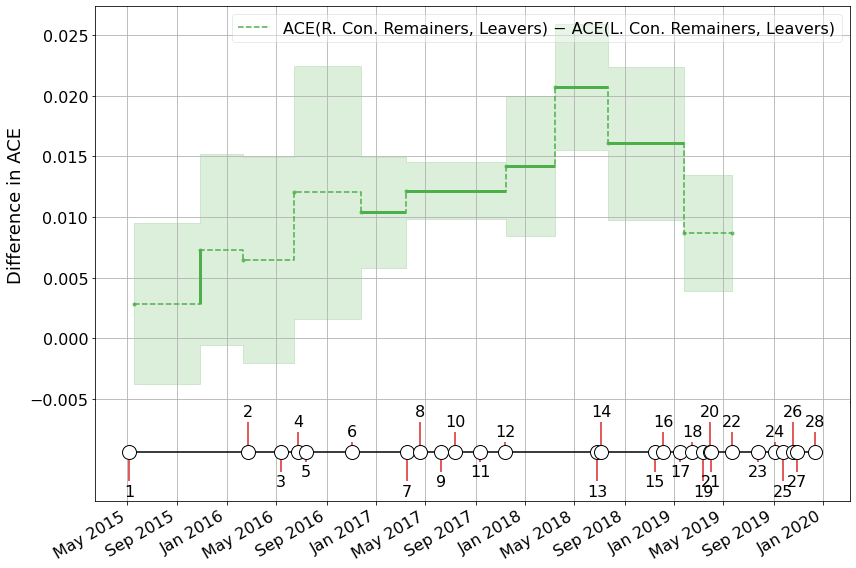

In [21]:
leaver_r_con_diff = leaver_r_con_runs - leaver_l_con_runs

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0)
ax = plt.subplot(gs[0])
ax_time = plt.subplot(gs[1], sharex=ax)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"]

means = leaver_r_con_diff.mean(axis=1)
stds = leaver_r_con_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax, colour=colour_list[2], label="ACE(R. Con. Remainers, Leavers) − ACE(L. Con. Remainers, Leavers)", line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=end_dates)
highlight_significant_changes(leaver_r_con_diff, end_dates, ax, colour_list[2], line_alpha=0)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(leaver_r_con_runs, leaver_l_con_runs, end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax, colour_list[2])

ax.set_ylabel("Difference in ACE", fontsize=18)

ax.grid()
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, framealpha=0.4)

names = np.arange(key_dates.shape[0]) + 1
dates = key_dates.index
plot_timeline(ax_time, dates, names, fontsize=16)
plt.setp(ax.get_xticklabels(), visible=False)
ax_time.spines['left'].set_visible(True)
ax_time.spines['right'].set_visible(True)

plt.tight_layout()

# fig.savefig(os.path.join(out_fp, "Remainer_Constituency_Differences.pdf"))

plt.show()

## Are MPs more defined by their party or their Referendum Stance?

In [22]:
party_comparisons = get_CE_comparisons(os.path.join(results_fp, "conservative_labour.json"))
end_dates = get_ends_of_windows(os.path.join(results_fp, "conservative_labour.json"))

con_con_runs = get_CE_means_fixed_windows(party_comparisons, "Conservative", "Conservative")
con_lab_runs = get_CE_means_fixed_windows(party_comparisons, "Conservative", "Labour")

lab_con_runs = get_CE_means_fixed_windows(party_comparisons, "Labour", "Conservative")
lab_lab_runs = get_CE_means_fixed_windows(party_comparisons, "Labour", "Labour")

con_con_means, con_con_stds = get_ce_mean_and_std(party_comparisons, "Conservative", "Conservative")
con_lab_means, con_lab_stds = get_ce_mean_and_std(party_comparisons, "Conservative", "Labour")

lab_con_means, lab_con_stds = get_ce_mean_and_std(party_comparisons, "Labour", "Conservative")
lab_lab_means, lab_lab_stds = get_ce_mean_and_std(party_comparisons, "Labour", "Labour")

In [23]:
ref_comparisons = get_CE_comparisons(os.path.join(results_fp, "remain_leave.json"))
ref_end_dates = get_ends_of_windows(os.path.join(results_fp, "remain_leave.json"))

remain_remain_runs = get_CE_means_fixed_windows(ref_comparisons, "remain", "remain")
remain_leave_runs = get_CE_means_fixed_windows(ref_comparisons, "remain", "leave")

leave_remain_runs = get_CE_means_fixed_windows(ref_comparisons, "leave", "remain")
leave_leave_runs = get_CE_means_fixed_windows(ref_comparisons, "leave", "leave")

remain_remain_means, remain_remain_stds = get_ce_mean_and_std(ref_comparisons, "remain", "remain")
remain_leave_means, remain_leave_stds = get_ce_mean_and_std(ref_comparisons, "remain", "leave")

leave_remain_means, leave_remain_stds = get_ce_mean_and_std(ref_comparisons, "leave", "remain")
leave_leave_means, leave_leave_stds = get_ce_mean_and_std(ref_comparisons, "leave", "leave")

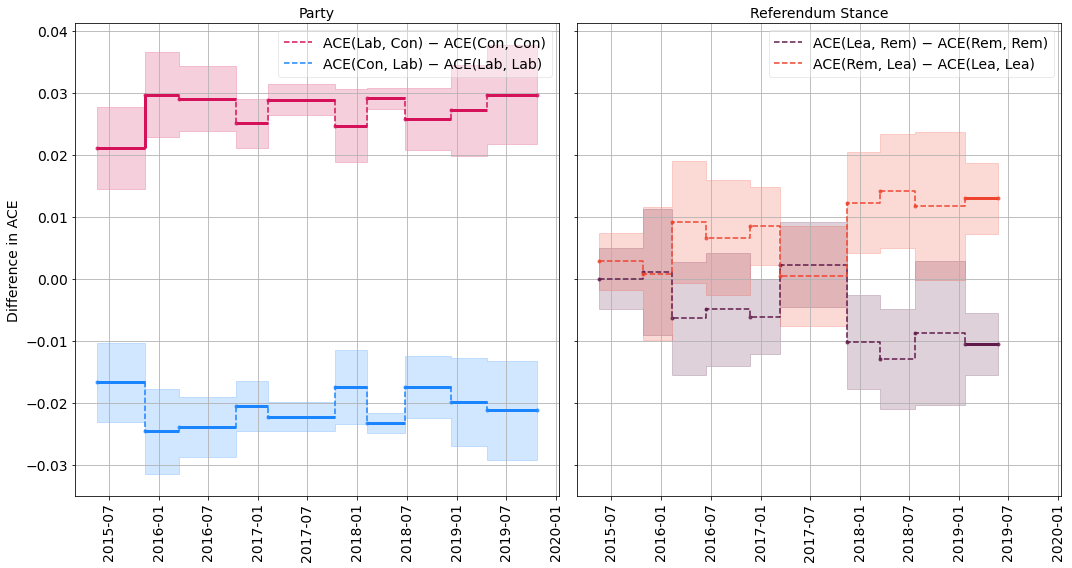

In [24]:
party_end_dates = get_ends_of_windows(os.path.join(results_fp, "conservative_labour.json"))
ref_end_dates = get_ends_of_windows(os.path.join(results_fp, "remain_leave.json"))

con_lab_diff = con_lab_runs - con_con_runs
lab_con_diff = lab_con_runs - lab_lab_runs

remain_leave_diff = remain_leave_runs - remain_remain_runs
leave_remain_diff = leave_remain_runs - leave_leave_runs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#D41159", "#1A85FF", "#601A4A", "#EE442F"]

means = con_lab_diff.mean(axis=1)
stds = con_lab_diff.std(axis=1)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(con_lab_runs, con_con_runs, party_end_dates, sig_level=0.01)]

plot_group_similarity_across_runs_stepped(means, stds, ax1, colour=colour_list[0], line_style="--", fill_alpha=0.2, label="ACE(Lab, Con) − ACE(Con, Con)", end_dates=party_end_dates, line_alpha=1)
plot_hlines(h_lines, ax1, colour_list[0])
highlight_significant_changes(con_lab_diff, party_end_dates, ax1, colour_list[0], line_alpha=0, sig_level=0.01)

means = lab_con_diff.mean(axis=1)
stds = lab_con_diff.std(axis=1)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(lab_con_runs, lab_lab_runs, party_end_dates, sig_level=0.01)]

plot_group_similarity_across_runs_stepped(means, stds, ax1, colour=colour_list[1], line_style="--", fill_alpha=0.2, label="ACE(Con, Lab) − ACE(Lab, Lab)", end_dates=party_end_dates, line_alpha=1)
plot_hlines(h_lines, ax1, colour_list[1])
highlight_significant_changes(lab_con_diff, party_end_dates, ax1, colour_list[1], line_alpha=0, sig_level=0.01)


ax1.title.set(text='Party', fontsize=14)
ax1.set_ylabel("Difference in ACE", fontsize=14)
ax1.grid()

means = remain_leave_diff.mean(axis=1)
stds = remain_leave_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax2, colour=colour_list[2], line_style="--", fill_alpha=0.2, label="ACE(Lea, Rem) − ACE(Rem, Rem)", end_dates=ref_end_dates, line_alpha=1)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(remain_leave_runs, remain_remain_runs, ref_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax2, colour_list[2])
highlight_significant_changes(remain_leave_diff, ref_end_dates, ax2, colour_list[2], line_alpha=0, sig_level=0.01)

means = leave_remain_diff.mean(axis=1)
stds = leave_remain_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax2, colour=colour_list[3], line_style="--", fill_alpha=0.2, label="ACE(Rem, Lea) − ACE(Lea, Lea)", end_dates=ref_end_dates, line_alpha=1)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(leave_remain_runs, leave_leave_runs, ref_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax2, colour_list[3])
highlight_significant_changes(leave_remain_diff, ref_end_dates, ax2, colour_list[3], line_alpha=0, sig_level=0.01)

ax2.title.set(text='Referendum Stance', fontsize=14)
ax2.grid()

ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

ax1.legend(fontsize=14, framealpha=0.4)
ax2.legend(fontsize=14, framealpha=0.4)

plt.tight_layout()

# fig.savefig(os.path.join(out_fp, "Identity.pdf"))

plt.show()

The above graph is slightly confusing because it appears that Labour is divergent from the Conservatives but the Conservatives are not divergent from Labour.

This problem emerges because of Labour's high unpredictability.

In [ ]:
eu_party_comparisons = get_CE_comparisons(os.path.join(results_fp_eu, "conservative_labour.json"))
eu_party_end_dates = get_ends_of_windows(os.path.join(results_fp_eu, "conservative_labour.json"))

eu_con_con_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Conservative", "Conservative")
eu_con_lab_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Conservative", "Labour")

eu_lab_con_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Labour", "Conservative")
eu_lab_lab_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Labour", "Labour")

eu_con_con_means, eu_con_con_stds = get_ce_mean_and_std(eu_party_comparisons, "Conservative", "Conservative")
eu_con_lab_means, eu_con_lab_stds = get_ce_mean_and_std(eu_party_comparisons, "Conservative", "Labour")

eu_lab_con_means, eu_lab_con_stds = get_ce_mean_and_std(eu_party_comparisons, "Labour", "Conservative")
eu_lab_lab_means, eu_lab_lab_stds = get_ce_mean_and_std(eu_party_comparisons, "Labour", "Labour")

In [ ]:
eu_ref_comparisons = get_CE_comparisons(os.path.join(results_fp_eu, "remain_leave.json"))
eu_ref_end_dates = get_ends_of_windows(os.path.join(results_fp_eu, "remain_leave.json"))

eu_remain_remain_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "remain", "remain")
eu_remain_leave_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "remain", "leave")

eu_leave_remain_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "leave", "remain")
eu_leave_leave_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "leave", "leave")

eu_remain_remain_means, eu_remain_remain_stds = get_ce_mean_and_std(eu_ref_comparisons, "remain", "remain")
eu_remain_leave_means, eu_remain_leave_stds = get_ce_mean_and_std(eu_ref_comparisons, "remain", "leave")

eu_leave_remain_means, eu_leave_remain_stds = get_ce_mean_and_std(eu_ref_comparisons, "leave", "remain")
eu_leave_leave_means, eu_leave_leave_stds = get_ce_mean_and_std(eu_ref_comparisons, "leave", "leave")

In [ ]:
con_lab_diff = eu_con_lab_runs - eu_con_con_runs
lab_con_diff = eu_lab_con_runs - eu_lab_lab_runs

remain_leave_diff = eu_remain_leave_runs - eu_remain_remain_runs
leave_remain_diff = eu_leave_remain_runs - eu_leave_leave_runs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#D41159", "#1A85FF", "#601A4A", "#EE442F"]

means = con_lab_diff.mean(axis=1)
stds = con_lab_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax1, colour=colour_list[0], line_style="--", line_alpha=1, fill_alpha=0.2, label="ACE(Lab, Con) − ACE(Con, Con)", end_dates=eu_party_end_dates)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(eu_con_lab_runs, eu_con_con_runs, eu_party_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax1, colour_list[0])
highlight_significant_changes(con_lab_diff, eu_party_end_dates, ax1, colour_list[0], sig_level=0.01)

means = lab_con_diff.mean(axis=1)
stds = lab_con_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax1, colour=colour_list[1], line_style="--", line_alpha=1, fill_alpha=0.2, label="ACE(Con, Lab) − ACE(Lab, Lab)", end_dates=eu_party_end_dates)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(eu_lab_con_runs, eu_lab_lab_runs, eu_party_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax1, colour_list[1])
highlight_significant_changes(lab_con_diff, eu_party_end_dates, ax1, colour_list[1], sig_level=0.01)


ax1.title.set(text='Party', fontsize=14)
ax1.set_ylabel("Difference in ACE", fontsize=14)
ax1.grid()

means = remain_leave_diff.mean(axis=1)
stds = remain_leave_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax2, colour=colour_list[2], line_style="--", line_alpha=1, fill_alpha=0.2, label="ACE(Lea, Rem) − ACE(Rem, Rem)", end_dates=eu_ref_end_dates)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(eu_remain_leave_runs, eu_remain_remain_runs, eu_ref_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax2, colour_list[2])
highlight_significant_changes(remain_leave_diff, eu_ref_end_dates, ax2, colour_list[2], sig_level=0.01)


means = leave_remain_diff.mean(axis=1)
stds = leave_remain_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax2, colour=colour_list[3], line_style="--", line_alpha=2, fill_alpha=0.2, label="ACE(Rem, Lea) − ACE(Lea, Lea)", end_dates=eu_ref_end_dates)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(eu_leave_remain_runs, eu_leave_leave_runs, eu_ref_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax2, colour_list[3])
highlight_significant_changes(leave_remain_diff, eu_ref_end_dates, ax2, colour_list[3], sig_level=0.01)


ax2.title.set(text='Referendum Stance', fontsize=14)
ax2.grid()

ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

ax1.legend(fontsize=14, framealpha=0.4)
ax2.legend(fontsize=14, framealpha=0.4)

plt.tight_layout()

# fig.savefig(os.path.join(out_fp, "EU_Identity.pdf"))

plt.show()

# How consistent were the groups over time?

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(28, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#D41159", "#1A85FF", "#601A4A", "#EE442F"]

plot_group_similarity_across_runs_stepped(con_con_means, con_con_stds, ax1, colour=colour_list[1], line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=party_end_dates)
highlight_significant_changes(con_con_runs, party_end_dates, ax1, colour_list[1], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(lab_lab_means, lab_lab_stds, ax2, colour=colour_list[0], line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=party_end_dates)
highlight_significant_changes(lab_lab_runs, party_end_dates, ax2, colour_list[0], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(leave_leave_means, leave_leave_stds, ax3, colour=colour_list[3], line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=ref_end_dates)
highlight_significant_changes(leave_leave_runs, ref_end_dates, ax3, colour_list[3], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(remain_remain_means, remain_remain_stds, ax4, colour=colour_list[2], line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=ref_end_dates)
highlight_significant_changes(remain_remain_runs, ref_end_dates, ax4, colour_list[2], line_alpha=0, sig_level=0.01)

ax1.title.set(text='Conservative', fontsize=18)
ax2.title.set(text='Labour', fontsize=18)

ax3.title.set(text='Leave', fontsize=18)
ax4.title.set(text='Remain', fontsize=18)

ax1.set_ylabel("Unpredictability", fontsize=18)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)

# plt.ylim(6.1, 6.9)
plt.tight_layout()

# fig.savefig(os.path.join(out_fp, "all_unpredictability.pdf"))

plt.show()

In [ ]:
eu_party_comparisons = get_CE_comparisons(os.path.join(results_fp_eu, "conservative_labour.json"))
eu_party_end_dates = get_ends_of_windows(os.path.join(results_fp_eu, "conservative_labour.json"))

eu_con_con_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Conservative", "Conservative")
eu_lab_lab_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Labour", "Labour")

eu_con_con_means, eu_con_con_stds = get_ce_mean_and_std(eu_party_comparisons, "Conservative", "Conservative")
eu_lab_lab_means, eu_lab_lab_stds = get_ce_mean_and_std(eu_party_comparisons, "Labour", "Labour")

eu_ref_comparisons = get_CE_comparisons(os.path.join(results_fp_eu, "remain_leave.json"))
eu_ref_end_dates = get_ends_of_windows(os.path.join(results_fp_eu, "remain_leave.json"))

eu_remain_remain_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "remain", "remain")
eu_leave_leave_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "leave", "leave")

eu_remain_remain_means, eu_remain_remain_stds = get_ce_mean_and_std(eu_ref_comparisons, "remain", "remain")
eu_leave_leave_means, eu_leave_leave_stds = get_ce_mean_and_std(eu_ref_comparisons, "leave", "leave")

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(28, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#D41159", "#1A85FF", "#601A4A", "#EE442F"]

plot_group_similarity_across_runs_stepped(eu_con_con_means, eu_con_con_stds, ax1, colour=colour_list[1], line_style="--", line_alpha=0.7,fill_alpha=0.2, end_dates=eu_party_end_dates)
highlight_significant_changes(eu_con_con_runs, eu_party_end_dates, ax1, colour_list[1], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(eu_lab_lab_means, eu_lab_lab_stds, ax2, colour=colour_list[0], line_style="--", line_alpha=0.7,fill_alpha=0.2, end_dates=eu_party_end_dates)
highlight_significant_changes(eu_lab_lab_runs, eu_party_end_dates, ax2, colour_list[0], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(eu_leave_leave_means, eu_leave_leave_stds, ax3, colour=colour_list[3], line_style="--", line_alpha=0.7, fill_alpha=0.2, end_dates=eu_ref_end_dates)
highlight_significant_changes(eu_leave_leave_runs, eu_ref_end_dates, ax3, colour_list[3], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(eu_remain_remain_means, eu_remain_remain_stds, ax4, colour=colour_list[2], line_style="--", line_alpha=0.7, fill_alpha=0.2, end_dates=eu_ref_end_dates)
highlight_significant_changes(eu_remain_remain_runs, eu_ref_end_dates, ax4, colour_list[2], line_alpha=0, sig_level=0.01)


ax1.title.set(text='Conservative', fontsize=18)
ax2.title.set(text='Labour', fontsize=18)

ax3.title.set(text='Leave', fontsize=18)
ax4.title.set(text='Remain', fontsize=18)

ax1.set_ylabel("Unpredictability", fontsize=18)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)

# plt.ylim(6.1, 6.9)
plt.tight_layout()

# fig.savefig(os.path.join(out_fp, "eu_unpredictability.pdf"))

plt.show()

# Keywords

In [ ]:
with open(os.path.join(kw_dir, "kw_against_non_eu.json")) as curr_file:
    eu_kw = json.load(curr_file)

In [ ]:
kw_rcon = pd.Series(eu_kw["r_con_remainers"])
kw_lcon = pd.Series(eu_kw["l_con_remainers"])
kw_leav = pd.Series(eu_kw["leavers"])

In [ ]:
def get_kw_diff_and_rank(kw1, kw2, cols):
    # Compare the local window vs ref to the global lab vs global ref.
    shared_kw = pd.concat([kw1, kw2], axis=1).dropna()
    shared_kw.columns = cols

    shared_kw["difference"] = shared_kw[cols[0]] - shared_kw[cols[1]]

    ranks1 = pd.Series(np.arange(1, len(shared_kw)+1), index=shared_kw.loc[:, cols[0]].sort_values(ascending=False).index)
    ranks2 = pd.Series(np.arange(1, len(shared_kw)+1), index=shared_kw.loc[:, cols[1]].sort_values(ascending=False).index)

    shared_kw["{} Rank".format(cols[0])] = ranks1
    shared_kw["{} Rank".format(cols[1])] = ranks2
    shared_kw["Rank Difference"] = -(shared_kw["{} Rank".format(cols[0])] - shared_kw["{} Rank".format(cols[1])])
    return shared_kw

In [ ]:
kw_rcon.head(20)

In [ ]:
kw_leav.head(20)

In [ ]:
kw_ranks = get_kw_diff_and_rank(kw_rcon, kw_leav, ["R-Con", "Leaver"])

In [ ]:
kw_ranks.head(20)

In [ ]:
kw_ranks.head(50).sort_values("difference", ascending=False).head(20)

In [ ]:
kw_ranks.head(20).sort_values("Rank Difference", ascending=False).head(20)

In [ ]:
kw_ranks = get_kw_diff_and_rank(kw_rcon, kw_lcon, ["R-Con", "L-Con"])

In [ ]:
kw_ranks.head(20)

In [ ]:
kw_ranks.head(50).sort_values("Rank Difference", ascending=False).head(20)

## KW of Lab/Con 2019 Dip

In [ ]:
with open(os.path.join(kw_dir, "2019_party_dip_kw_v_before.json")) as curr_file:
    kw = json.load(curr_file)

In [ ]:
lab_kw = pd.Series(kw["lab"])
con_kw = pd.Series(kw["con"])

In [ ]:
lab_kw.head(20)

In [ ]:
con_kw.head(20)

In [ ]:
with open(os.path.join(kw_dir, "2019_party_dip_kw_change.json")) as curr_file:
    kw = json.load(curr_file)

In [ ]:
lab_kw = pd.Series(kw["lab"])
con_kw = pd.Series(kw["con"])

In [ ]:
lab_kw.head(20)

In [ ]:
con_kw.head(20)